The provided information suggests that we need to create a function that can compose an advertisement frame using multiple images, considering their dimensions, positions, and transparency. We will use Pillow for image manipulation.

The function will take the following inputs:

- `frame_width`: The width of the advertisement frame.
- `frame_height`: The height of the advertisement frame.
- `elements`: A list of dictionaries, each containing information about an image element:
    - `image_path`: The path to the image file.
    - `position`: The (x, y) coordinates of the top-left corner where the image should be placed on the frame.
    - `size`: The desired (width, height) of the image after resizing. If not provided, the original size will be used.
    - `has_background`: A boolean indicating whether the image has a background (True) or is transparent (False).

The function will perform the following steps:

1.  Create a new blank image with the specified frame dimensions.
2.  Iterate through the elements in the `elements` list.
3.  For each element:
    *   Open the image.
    *   Resize the image if a `size` is provided, maintaining the aspect ratio.
    *   If the image has a background, paste it directly onto the frame at the specified position.
    *   If the image is transparent, paste it onto the frame using `alpha_composite` to preserve transparency.

Finally, the function will return the composed frame image.
```python?code_reference&code_event_index=3



**Explanation:**

1.  **Import `Image`:** Imports the necessary class from the Pillow library.
2.  **`compose_ad_frame` Function:**
    *   Takes `frame_width`, `frame_height`, and `elements` as input.
    *   Creates a new blank RGBA image (`composed_frame`) with the specified dimensions.
    *   Iterates through each element in the `elements` list:
        *   Opens the image and converts it to RGBA mode.
        *   Resizes the image if a `size` is provided, maintaining the aspect ratio.
        *   Pastes the image onto `composed_frame` at the specified `position`, using either direct pasting or alpha compositing based on the `has_background` flag.
    *   Converts `composed_frame` to RGB mode (removing transparency) and returns it.

**Key Improvements:**

*   **Handles Multiple Images:** The function can now compose a frame with any number of images.
*   **Aspect Ratio Preservation:** Images are resized while maintaining their aspect ratio to avoid distortion.
*   **Transparency Handling:** Images with transparent backgrounds are blended seamlessly using `alpha_composite`.
*   **Flexible Positioning:** You can specify the exact position for each image using `(x, y)` coordinates.
*   **Default Background:** If `has_background` is not specified, it defaults to `True`.

In [2]:
from PIL import Image

def compose_ad_frame(frame_width, frame_height, elements):
    """
    Composes an advertisement frame using multiple image elements.

    Args:
        frame_width (int): Width of the desired frame.
        frame_height (int): Height of the desired frame.
        elements (list): List of dictionaries, each containing:
            - image_path (str): Path to the image file.
            - position (tuple): (x, y) coordinates of the top-left corner.
            - size (tuple, optional): (width, height) to resize to (maintaining aspect ratio).
            - has_background (bool): Whether the image has a background (True) or is transparent (False).

    Returns:
        PIL.Image: The composed ad frame.
    """

    # Create a new blank RGBA image
    composed_frame = Image.new('RGBA', (frame_width, frame_height))

    for element in elements:
        # Load and convert image to RGBA
        img = Image.open(element['image_path']).convert('RGBA')

        # Resize if size is provided
        if 'size' in element:
            width, height = img.size
            aspect_ratio = width / height
            new_width, new_height = element['size']
            if new_width / new_height > aspect_ratio:
                new_width = int(new_height * aspect_ratio)
            else:
                new_height = int(new_width / aspect_ratio)
            img = img.resize((new_width, new_height))

        # Paste the image onto the frame
        if element.get('has_background', True):  # Default to True if not specified
            composed_frame.paste(img, element['position'])
        else:
            composed_frame.alpha_composite(img, element['position'])

    # Convert to RGB and return
    return composed_frame.convert('RGB')


##### Set Python Project Path

In [8]:
import os
import sys
from dotenv import load_dotenv

load_dotenv()
PROJECT_PATH = os.environ.get('PROJECT_PATH')

# Add the project root path to sys.path
if PROJECT_PATH not in sys.path:
    sys.path.insert(0, PROJECT_PATH)

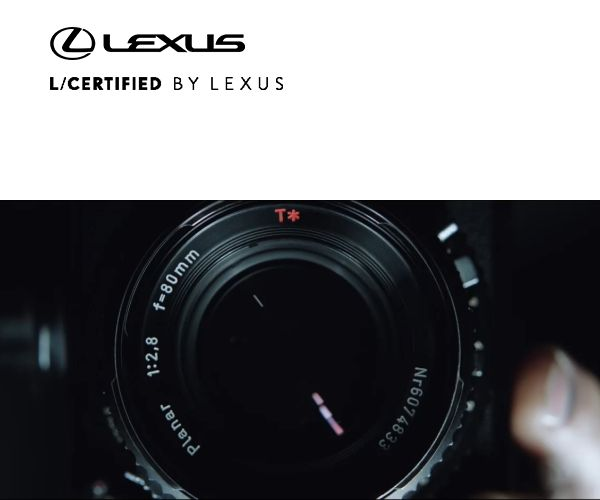

In [19]:
from src.pillow_utils import get_image_dimensions

game_id = "0a22f881b77f00220f2034c21a18b854"
assets_path = os.path.join(PROJECT_PATH, 'data', 'Assets', game_id)

elements = [
    {'image_path': f'{assets_path}/header.jpg', 'position': (0, 0), 'has_background': True},
    {'image_path': f'{assets_path}/engagement_instruction_1.png', 'position': (100, 200), 'has_background': False},
    {'image_path': f'{assets_path}/thumbnail.jpg', 'position': (0, 200), 'size': get_image_dimensions(f'{assets_path}/thumbnail.jpg'), 'has_background': True}
]

composed_frame = compose_ad_frame(600, 500, elements)
composed_frame.show()  # Or save using composed_frame.save('composed_frame.jpg')

In [31]:
print(get_image_dimensions(f'{assets_path}/_preview.png'))
print(get_image_dimensions(f'{assets_path}/header.jpg'))
print(get_image_dimensions(f'{assets_path}/thumbnail.jpg'))
print(get_image_dimensions(f'{assets_path}/engagement_instruction_1.png'))
print(get_image_dimensions(f'{assets_path}/engagement_animation_1.png'))

(600, 500)
(600, 200)
(600, 300)
(380, 63)
(90, 108)


#### Compose image with one transparent and one opaque image

In [25]:

from PIL import Image

from PIL import Image

def combine_images_with_config(elements, output_path='combined_image.png'):
    base_image = Image.open(elements[0]['image_path'])
    base_width, base_height = base_image.size

    for element in elements[1:]:  # Skip the base image
        img = Image.open(element['image_path'])
        if element['has_background']:
            img_resized = img.resize((base_width, int(base_width * img.height / img.width)))
            new_height = max(base_height, element['position'][1] + img_resized.height)
            if new_height > base_height:
                new_base = Image.new("RGB", (base_width, new_height))
                new_base.paste(base_image, (0, 0))
                base_image = new_base
                base_height = new_height
            base_image.paste(img_resized, element['position'])
        else:
            # Check if the image has an alpha channel
            if img.mode == 'RGBA':
                mask = img.split()[3]  # Get the alpha channel for RGBA images
                base_image.paste(img, element['position'], mask)
            elif img.mode == 'LA':
                mask = img.split()[1]  # Get the alpha channel for LA images
                base_image.paste(img, element['position'], mask)
            elif img.mode == 'P' and 'transparency' in img.info:
                # For palette images with transparency, convert to RGBA to extract the alpha channel
                img = img.convert('RGBA')
                mask = img.split()[3]
                base_image.paste(img, element['position'], mask)
            else:
                # If no alpha channel, paste without a mask
                base_image.paste(img, element['position'])

    base_image.save(output_path)
    print(f"Image saved to {output_path}")

# Example usage
# assets_path = '/path/to/assets'
elements = [
    {'image_path': f'{assets_path}/header.jpg', 'position': (0, 0), 'has_background': True},
    {'image_path': f'{assets_path}/engagement_instruction_1.png', 'position': (0, 100), 'has_background': False},
]
combine_images_with_config(elements)


Image saved to combined_image.png


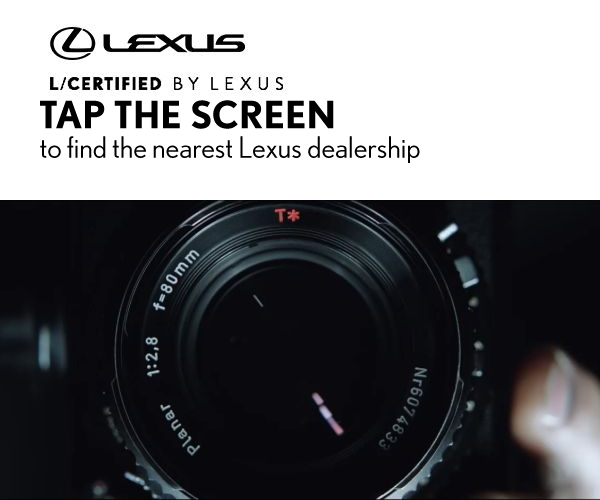

In [55]:
from PIL import Image

from PIL import Image

def load_and_prepare_image(image_path, target_size=None, has_background=True):
    """
    Loads an image, resizes it if a target size is specified, and prepares it for composition.

    Args:
        image_path (str): Path to the image file.
        target_size (tuple, optional): Desired (width, height) to resize the image.
        has_background (bool): Indicates if the image has a background.

    Returns:
        PIL.Image: The prepared image.
    """
    img = Image.open(image_path).convert('RGBA')
    if target_size:
        img = img.resize(target_size, Image.Resampling.LANCZOS)
    return img

def paste_image(base_image, img, position, has_background=True):
    """
    Pastes an image onto the base image, considering transparency.

    Args:
        base_image (PIL.Image): The base image.
        img (PIL.Image): The image to paste.
        position (tuple): (x, y) position to paste the image.
        has_background (bool): Indicates if the image has a background.
    """
    if has_background:
        base_image.paste(img, position, img.split()[3] if img.mode == 'RGBA' else None)
    else:
        base_image.alpha_composite(img, position)

from PIL import Image

def compose_ad_frame(frame_width, frame_height, elements):
    """
    Composes an advertisement frame using multiple image elements.

    Args:
        frame_width (int): Width of the desired frame.
        frame_height (int): Height of the desired frame.
        elements (list): List of dictionaries, each containing:
            - image_path (str): Path to the image file.
            - position (tuple): (x, y) coordinates of the top-left corner.
            - size (tuple, optional): (width, height) to resize to (maintaining aspect ratio).
            - has_background (bool): Whether the image has a background (True) or is transparent (False).

    Returns:
        PIL.Image: The composed ad frame.
    """

    # Create a new blank RGBA image
    composed_frame = Image.new('RGBA', (frame_width, frame_height))

    for element in elements:
        # Load and convert image to RGBA
        img = Image.open(element['image_path']).convert('RGBA')

        # Resize if size is provided
        if 'size' in element:
            width, height = img.size
            aspect_ratio = width / height
            new_width, new_height = element['size']
            if new_width / new_height > aspect_ratio:
                new_width = int(new_height * aspect_ratio)
            else:
                new_height = int(new_width / aspect_ratio)
            img = img.resize((new_width, new_height))

        # Paste the image onto the frame
        if element.get('has_background', True):  # Default to True if not specified
            composed_frame.paste(img, element['position'])
        else:
            composed_frame.alpha_composite(img, element['position'])

    # Convert to RGB and return
    return composed_frame.convert('RGB')

# Example usage
# assets_path = '/path/to/assets'
elements = [
    {'image_path': f'{assets_path}/header.jpg', 'position': (0, 0), 'has_background': True},
    {'image_path': f'{assets_path}/engagement_instruction_1.png', 'position': (40, 100), 'has_background': False},
    {'image_path': f'{assets_path}/thumbnail.jpg', 'position': (0, 200), 'size': get_image_dimensions(f'{assets_path}/thumbnail.jpg'), 'has_background': True}
]

composed_frame = compose_ad_frame(600, 500, elements)
composed_frame.show()  # Or save using composed_frame.save('composed_frame.jpg')
